In [2]:
import regex as re
import pandas as pd
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")  

2023-04-07 09:10:46.238552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 09:10:48.688984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 09:10:48.692022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 09:10:48.802539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there m

In [3]:
fname = "../data/snippets/validated_snippets_run21_ncses_4.6.2023.csv"

validated_snippets = pd.read_csv(fname)

In [4]:
validated_snippets.head()

,Unnamed: 0,dyad_id,m1_score,m2_score,m3_score,m4_score,mention_candidate,snippet
0,0,634174,0.166,NaN,0.997,NaN,schools and staffing survey,d scope of minority teacher recruitment polici...
1,1,634178,0.539,0.539,0.993,0.539,common core of data,r publication of this article. \nThe offense “...
2,2,634242,0.661,NaN,0.998,NaN,education longitudinal study,students of varying levels of academic prepara...
3,3,634299,0.538,1.000,0.990,1.000,trends in international mathematics and scienc...,nsitivity of Achievement Estimation to Conditi...
4,4,634301,0.575,0.575,1.000,0.575,nces common core of data,ym districts (denoted by asterisks) have round...


<AxesSubplot: >

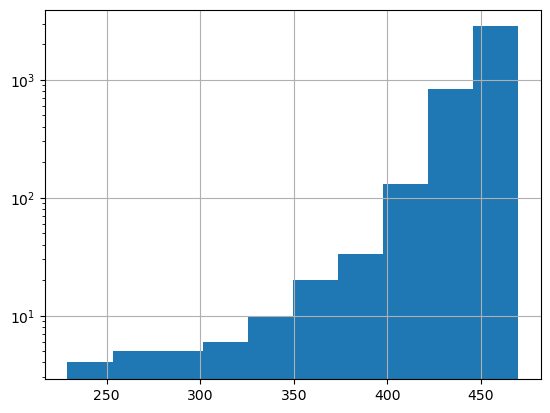

In [5]:
validated_snippets["snippet"].apply(len).hist(log=True)

<AxesSubplot: >

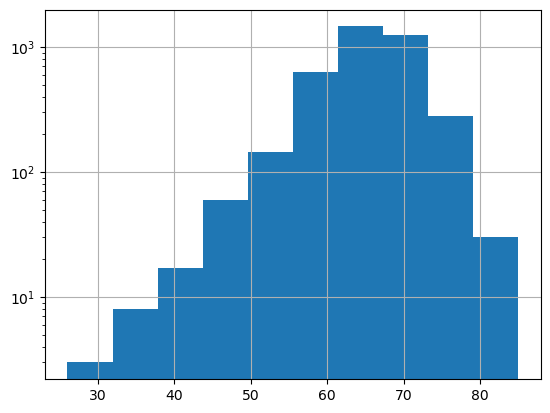

In [6]:
validated_snippets["snippet"].apply(lambda x: len(x.split())).hist(log=True)

We need to transform snippets into the three kinds of snippets that models 
can use: NER, classification, and masked LM.

In [7]:
def simple_existence_check(row:pd.DataFrame) -> bool:
    """Check if a snippet exists in a row of a dataframe"""
    return row["mention_candidate"] in row["snippet"].lower()

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<AxesSubplot: >

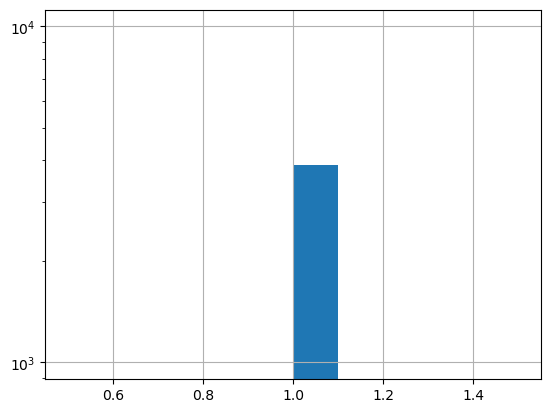

In [8]:
validated_snippets["simple_match"] = validated_snippets.apply(simple_existence_check, axis=1)
validated_snippets["simple_match"].hist(log=True)

All labels can be found using simple string matching so we'll use that to 
generate the labels.


### NER

In [9]:
from typing import List


def tokenize(row:pd.DataFrame) -> List[str]:
    return list(map(lambda s: str(s).strip().lower(), nlp(re.subn(
        r"[\\][\\n]",
        " ", 
        row["snippet"],
    )[0]).doc))

validated_snippets["tokens"] = validated_snippets.apply(tokenize, axis=1)

In [21]:
def build_ner_label(row:pd.DataFrame) -> str:
    tokens = row["tokens"]
    lbl_tokens = row["mention_candidate"].split()
    lbl = ["B-DAT"] + ["I-DAT"] * (len(lbl_tokens) - 1)
    token_lbls = ["O"] * len(tokens)

    valid = True
    try:
        start = tokens.index(lbl_tokens[0])
        token_lbls[start:start + len(lbl_tokens)] = lbl
    except Exception as e:
        valid = False

    if valid:
        return " ".join(token_lbls)
    else:
        return ""

validated_snippets["ner_label"] = validated_snippets.apply(build_ner_label, axis=1)

In [11]:


from typing import Dict, List, Tuple, Union

def extract_entities_for_visualization(
    text: List[str], ner_tags: List[str]
) -> List[Dict[str, Union[int, str]]]:
    """Extracts entities from a list of tokens and their corresponding NER tags.
    Args:
        text (List[str]): The list of tokens.
        ner_tags (List[str]): The list of NER tags.
        Returns:
            List[Dict[str, Any]]: A list of entities, each entity is a dictionary
                                  with the following keys:
                                    - start: The start index of the entity.
                                    - end: The end index of the entity.
                                    - label: The label of the entity.
    """
    entities = []
    start = 0
    end = 0
    in_ent = False
    for token, tag in zip(text, ner_tags):
        token_length = len(token) + 1  # plus a space
        if tag in ["B-DAT", "I-DAT"]:
            in_ent = True
            end += token_length
        elif tag == "O" and in_ent:
            entities.append({"start": start, "end": end, "label": "Dataset"})
            in_ent = False
            start = end
        else:
            # just an O tag
            start += token_length
            end = start

    return entities


def visualize_ner_tags(text: str, ner_tags: List[str]) -> Tuple[str, str, str]:
    """Visualize NER tags in a text."""

    tokens = list(map(
            lambda s: str(s).strip().lower(), 
            nlp(re.subn(
                r"[\\][\\n]",
                " ", 
                text,
            )[0]).doc))

    entities = extract_entities_for_visualization(
        tokens, 
        ner_tags
    )

    ex = [{"text": " ".join(tokens), "ents": entities, "title": None}]

    displacy.render(
        ex,
        style="ent",
        manual=True,
        options={"colors": {"Dataset": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}},
    )

idx = 30
visualize_ner_tags(
    text=validated_snippets["snippet"].iloc[idx],
    ner_tags=validated_snippets["ner_label"].iloc[idx].split(),
)

### Classification

In [12]:
validated_snippets["label"] = 1.0


,Unnamed: 0,dyad_id,m1_score,m2_score,m3_score,m4_score,mention_candidate,snippet,simple_match,tokens,ner_label
0,0,634174,0.166,NaN,0.997,NaN,schools and staffing survey,d scope of minority teacher recruitment polici...,True,"[d, scope, of, minority, teacher, recruitment,...",O O O O O O O O O O O O O O O O O O O O O O O ...
1,1,634178,0.539,0.539,0.993,0.539,common core of data,r publication of this article. \nThe offense “...,True,"[r, publication, of, this, article, ., , the, ...",O O O O O O O O O O O O O O O O O O O O O O O ...
2,2,634242,0.661,NaN,0.998,NaN,education longitudinal study,students of varying levels of academic prepara...,True,"[students, of, varying, levels, of, academic, ...",O O O O O O O O O O O O O O O O O O O O O O O ...
3,3,634299,0.538,1.000,0.990,1.000,trends in international mathematics and scienc...,nsitivity of Achievement Estimation to Conditi...,True,"[nsitivity, of, achievement, estimation, to, c...",O O O O O O O O O O O O O O O O O O O O O O O ...
4,4,634301,0.575,0.575,1.000,0.575,nces common core of data,ym districts (denoted by asterisks) have round...,True,"[ym, districts, (, denoted, by, asterisks, ), ...",O O O O O O O O O O O O O O O O O O O O O O O ...
...,...,...,...,...,...,...,...,...,...,...,...
3877,3877,890878,0.520,0.609,0.992,0.609,beginning postsecondary students longitudinal ...,ents switch meta-majors what type of major do ...,True,"[ents, switch, meta, -, majors, what, type, of...",O O O O O O O O O O O O O O O O O O O O O O O ...
3878,3878,890936,0.718,0.718,0.998,0.718,education longitudinal study,1 -0.1\n0.0 0.0 0.0\n** ** **\n0.0 0.0 0.0\n0....,True,"[1, -0.1, 0.0, 0.0, 0.0, *, *, *, *, *, *, 0.0...",O O O O O O O O O O O O O O O O O O O O O O O ...
3879,3879,891062,0.427,0.373,NaN,0.373,private school universe survey,n the school supplement collected from the Nat...,True,"[n, the, school, supplement, collected, from, ...",O O O O O O O O O O O O O O O O O O O O O O O ...
3880,3880,891080,0.539,0.615,1.000,0.615,national center for education statistics commo...,2012 to 2013 school year; and West Virginia w...,True,"[, 2012, to, 2013, school, year, ;, and, west,...",O O O O O O O O O O O O O O O O O O O O O O O ...


### Masked LM

In [22]:
def masked_lm_label(row:pd.DataFrame) -> str:
    ner = row["ner_label"]
    return " "

validated_snippets.apply(masked_lm_label, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
3877    None
3878    None
3879    None
3880    None
3881    None
Length: 3882, dtype: object